# CIND 820 Project


## Library Installation and Imports
To support the text preprocessing, sentiment analysis, and data visualization tasks, we begin by installing and importing the necessary libraries.

- **TextBlob** will be used for basic sentiment polarity and subjectivity scoring.

- **NRCLex** allows us to extract emotion-related scores based on the NRC Emotion Lexicon.

- **NLTK** provides access to stopwords and additional text preprocessing utilities.

- **Pandas** and **NumPy** are essential for data manipulation and analysis.

- **Matplotlib** and **Seaborn** will be used for creating informative visualizations throughout the exploratory data analysis (EDA).

Installation commands for textblob and nrclex are executed along with downloading necessary corpora for TextBlob. Once installed, all relevant libraries are imported to ensure a seamless workflow for the rest of the notebook.

In [2]:
#Install and import necessary libraries
!pip install textblob
!pip install nrclex
!pip install wordcloud
!python -m textblob.download_corpora
from textblob import TextBlob
from nrclex import NRCLex
import nltk
import spacy
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time




INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=54d874ed0b99ef843aec13032ac81fc8043bd3650852004740415a1373012e28
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nlt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataset Acquisition
We will be using the ISOT Fake News Dataset, which contains two separate CSV files: one for fake news articles and another for real news. To obtain the data, we are dowloading and extracting the ZIP file from the University of Victoria’s official repository:
`https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip`

A copy of the zip file is also made available in the GitHub repository.

The two CSV files, Fake.csv and True.csv are loaded into separate pandas DataFrames. To facilitate further analysis, we also introduced a new column called authenticity, where:
- 0 represents fake news
- 1 represents real news

This binary label will serve as our target variable for classification and analysis throughout the project.

In [2]:

#Download the dataset
import requests
import zipfile
import io

# Download the ZIP file
url = "https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip"
response = requests.get(url)

# Unzip the file into memory
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.printdir()
    # Assuming a CSV file inside:
    with z.open("Fake.csv") as f:
        fake_news = pd.read_csv(f)
    with z.open("True.csv") as f:
        real_news = pd.read_csv(f)

# Add 'Credibility' column
fake_news['authenticity'] = 0  # 0 for fake news
real_news['authenticity'] = 1  # 1 for real news



File Name                                             Modified             Size
Fake.csv                                       2018-03-12 16:20:52     62789876
True.csv                                       2018-03-12 16:21:36     53582940


Now that we’ve loaded both the fake and real news articles, we’ll go ahead and combine them into a single DataFrame. This makes it easier to work with the full dataset in one place.

To make sure everything looks good, we printed out the first and last few rows of the combined dataset. We also used `.info()` to check the data types and make sure there are no missing values in any of the key columns.

Everything seems to be in order, so we’re ready to move on to data cleaning.

In [3]:
# Combine the datasets
df = pd.concat([fake_news, real_news], ignore_index=True)
# Display the first and last few rows of the combined dataset to verify
print(df.head())
print(df.tail())

# Display the info to check data types and non-null counts
df.info()

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  authenticity  
0  December 31, 2017             0  
1  December 31, 2017             0  
2  December 30, 2017             0  
3  December 29, 2017             0  
4  December 25, 2017             0  
                                                   title

## Data Preparation
To keep things focused, we are dropping the title and subject columns from the dataset. For this analysis, we’re mainly interested in the full article text and its authenticity label, so those extra fields won’t be needed.

In [4]:
# Drop the 'title' and 'subject' columns from the dataframe
df = df.drop(['title', 'subject'], axis=1)
df.tail()


,text,date,authenticity
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,"August 22, 2017",1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...","August 22, 2017",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,"August 22, 2017",1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,"August 22, 2017",1
44897,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,"August 22, 2017",1


### Text Cleaning & Emotion Scoring Setup
Before diving into the analysis, we set up a few helper functions to clean and process the text data.

We defined a list of NRC emotion categories (like anger, joy, fear, etc.) that we’ll use later to analyze the emotional tone of each article.

We also downloaded a list of English stopwords using NLTK so we can remove common filler words that don’t add much meaning (like “the,” “and,” “is”).

In [5]:
#NRC Emotions list
nrc_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'negative', 'positive', 'sadness', 'surprise', 'trust']

stop_words = set(stopwords.words('english'))

To prep the articles:

- We have the `basic_cleaning()` function that removes things like URLs, dates, punctuation, numbers, and extra whitespace.

- Then, with `preprocess_text()`, we apply lemmatization and filter out stopwords for cleaner, more meaningful tokens.

In [6]:
import re
import spacy

def basic_cleaning(text):
    text = str(text).lower()
    # text = expand_contractions(text)
    text = re.sub(r"http\S+|www.\S+", "", text)           # remove URLs
    text = re.sub(r"\d{1,2}/\d{1,2}/\d{2,4}", "", text)    # remove dates like 12/31/2022
    text = re.sub(r"\d{4}-\d{2}-\d{2}", "", text)          # remove dates like 2022-12-31
    text = re.sub(r"\breuters\b", "", text)               # remove the word "reuters"
    text = re.sub(r"'s\b", "", text)                      # remove possessive 's
    text = re.sub(r"\d+", "", text)                       # remove numbers
    text = re.sub(r"[^\w\s]", "", text)                   # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()              # remove extra whitespace
    return text


# TextBlob-based lemmatization
def preprocess_text(text, method='textblob'):
    cleaned = basic_cleaning(text)

    if method == 'textblob':
        blob = TextBlob(cleaned)
        filtered = [word for word in blob.words if word.lower() not in stop_words]
        lemmatized = ' '.join([word.lemmatize() for word in filtered])

    elif method == 'spacy':
        doc = nlp(cleaned)
        filtered = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        lemmatized = ' '.join(filtered)

    else:
        raise ValueError("Invalid method. Choose 'textblob' or 'spacey'.")

    return lemmatized


# # TextBlob-based lemmatization
# def preprocess_text(text):
#     cleaned = basic_cleaning(text)
#     blob = TextBlob(cleaned)
#     filtered = [word for word in blob.words if word.lower() not in stop_words] # remove stopwords
#     lemmatized = ' '.join([word.lemmatize() for word in filtered])
#     return lemmatized

We also created some utility functions to help with scoring:

- `get_sentiment()` uses TextBlob to give us a polarity (positive vs. negative tone) and subjectivity (objective vs. opinionated) score.

- `get_emotion_vector()` maps the text to a 10-dimensional vector based on the NRC Emotion Lexicon.

- `count_emotion_words()` and `count_total_words()` help us quantify how much emotional language is present and how long each article is.

With these tools ready, we’re all set to start extracting features and running our analysis

In [7]:
# TextBlob sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# NRC Emotion Lexicon — convert to fixed-score vector
def get_emotion_vector(text):
    emotions = NRCLex(text).raw_emotion_scores
    return [emotions.get(e, 0) for e in nrc_emotions]

def count_emotion_words(text):
    emotions = NRCLex(text).raw_emotion_scores
    return sum(emotions.values())

# Total number of words in the cleaned text
def count_total_words(text):
    return len(TextBlob(text).words)


In [11]:
# Clean and lemmatize
df['text_clean'] = df['text'].apply(lambda x: preprocess_text(x, method='textblob'))
df['text_clean_spacey'] = df['text'].apply(lambda x: preprocess_text(x, method='spacy'))

# Sentiment
df[['text_polarity', 'text_subjectivity']] = df['text_clean'].apply(lambda x: pd.Series(get_sentiment(x)))

df['emotion_word_count'] = df['text_clean'].apply(count_emotion_words)
df['total_word_count'] = df['text'].apply(count_total_words)

# Emotions: one column per emotion
text_emotion_df = df['text_clean'].apply(lambda x: pd.Series(get_emotion_vector(x), index=[f"{e}" for e in nrc_emotions]))

# Combine with original DataFrame
df = pd.concat([df, text_emotion_df], axis=1)

In [12]:
print(df.tail())
df.info()

                                                    text              date  \
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  August 22, 2017    
44894  LONDON (Reuters) - LexisNexis, a provider of l...  August 22, 2017    
44895  MINSK (Reuters) - In the shadow of disused Sov...  August 22, 2017    
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  August 22, 2017    
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  August 22, 2017    

       authenticity                                         text_clean  \
44893             1  brussels nato ally tuesday welcomed president ...   
44894             1  london lexisnexis provider legal regulatory bu...   
44895             1  minsk shadow disused sovietera factory minsk s...   
44896             1  moscow vatican secretary state cardinal pietro...   
44897             1  jakarta indonesia buy sukhoi fighter jet worth...   

                                       text_clean_spacey  text_polarity  \
44893  brus

### Normalizing Emotion Scores
To make the emotion scores more meaningful and comparable across articles of different lengths, each emotion is normalized by dividing it by the total word count of the article. This gives a better sense of how frequently each emotion appears relative to the amount of content.

A quick safety check is also added to handle any weird cases like division by zero — replacing any infinite or missing values with NaN for now.

After that, the normalized emotion columns is pulled out into a new DataFrame called emotion_data, which we’ll use for further analysis and scaling.

Everything looks good and ready to go!

In [13]:
# Normalize emotion columns by dividing by total_word_count
for emotion in nrc_emotions:
  df[f'{emotion}_normalized'] = df[emotion] / df['total_word_count']

# Handle potential division by zero (replace inf or NaN with 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.fillna(0, inplace=True)


# Select only the normalized emotion columns for scaling
normalized_emotion_columns = [f'{e}_normalized' for e in nrc_emotions]
emotion_data = df[normalized_emotion_columns]

print(df.head())
print(df.tail())
df.info()


                                                text               date  \
0  Donald Trump just couldn t wish all Americans ...  December 31, 2017   
1  House Intelligence Committee Chairman Devin Nu...  December 31, 2017   
2  On Friday, it was revealed that former Milwauk...  December 30, 2017   
3  On Christmas day, Donald Trump announced that ...  December 29, 2017   
4  Pope Francis used his annual Christmas Day mes...  December 25, 2017   

   authenticity                                         text_clean  \
0             0  donald trump wish american happy new year leav...   
1             0  house intelligence committee chairman devin nu...   
2             0  friday revealed former milwaukee sheriff david...   
3             0  christmas day donald trump announced would bac...   
4             0  pope francis used annual christmas day message...   

                                   text_clean_spacey  text_polarity  \
0  donald trump couldn t wish americans happy new...     

Now, let's take a look at how long the articles are based on their authenticity label (real vs. fake).

In [14]:

print('Article length statistics:')
print(df.groupby('authenticity')['total_word_count'].describe())


Article length statistics:
                count        mean        std  min    25%    50%    75%     max
authenticity                                                                  
0             23481.0  424.915038  410.03057  0.0  240.0  365.0  507.0  8141.0
1             21417.0  395.302377  283.59143  0.0  150.0  367.0  536.0  5426.0


- Fake news articles (authenticity = 0) tend to be slightly longer on average, with a mean word count of ~425 words, compared to ~395 words for real news (authenticity = 1).

- Both types of articles have similar medians (~365–367 words), but fake articles show more variability, with a higher standard deviation and a much larger maximum length (up to 8,141 words vs. 5,426 for real).

- The interquartile range (25%–75%) also suggests fake articles are generally longer and more spread out in length.

This indicates that fake news may often include more content, which is possibly a tactic to appear more detailed or convincing.

Now, let's quickly take look at the descriptive statistics for the normalized positive and negative emotion scores.

This summary gives us a sense of the average intensity, spread, and range of positive and negative language used across all articles. It’s a helpful way to understand the overall emotional tone before diving into deeper comparisons.

In [15]:
# prompt: show descriptive statistics of positive_normalized and negative_normalized

print("\nDescriptive Statistics for Normalized Positive and Negative Emotions:")
print(df[['positive_normalized', 'negative_normalized']].describe())


Descriptive Statistics for Normalized Positive and Negative Emotions:
       positive_normalized  negative_normalized
count         44267.000000         44267.000000
mean              0.062890             0.041668
std               0.026707             0.021554
min               0.000000             0.000000
25%               0.047619             0.027397
50%               0.060738             0.039711
75%               0.075507             0.053675
max               1.000000             0.333333


Looking at the descriptive stats, we can see that positive emotion scores are generally a bit higher than negative ones across the dataset:

- The average positive score is around 0.063, compared to 0.042 for negative.

- Both distributions are fairly tight, with relatively low standard deviations.

- Most articles fall within a narrow range, but a few outliers show up — especially on the positive side, which peaks at a maximum of 1.0 (likely due to very short, highly positive texts).

- The median values (around 0.061 for positive and 0.040 for negative) also support the trend of more positively framed language overall.

This suggests that, on average, all the articles lean slightly more positive than negative in emotional tone.

## Data Analysis
### Fake vs Real News WordCloud
To get a visual sense of the language used in fake and real news articles, word clouds were generated for each group. All cleaned text from each category was combined, and the most frequently used words were visualized.

In [16]:

from wordcloud import WordCloud

# Combine all text for each authenticity group
fake_text = " ".join(df[df['authenticity'] == 0]['text_clean'].dropna())
real_text = " ".join(df[df['authenticity'] == 1]['text_clean'].dropna())


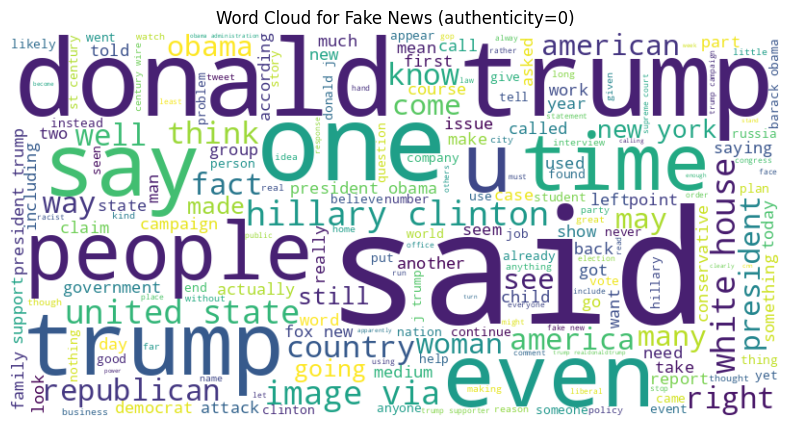

In [14]:

# Generate word cloud for fake news
wordcloud_fake = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(fake_text)

# Plot the word cloud for fake news
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News (authenticity=0)')
plt.show()

**Fake News (authenticity = 0)**

This word cloud is filled with emotionally charged or attention-grabbing terms. Names like Donald, Trump, and Hillary Clinton appear prominently, along with vague and conversational words like people, one, image, and even. The language leans toward sensationalism, with less emphasis on structured reporting.

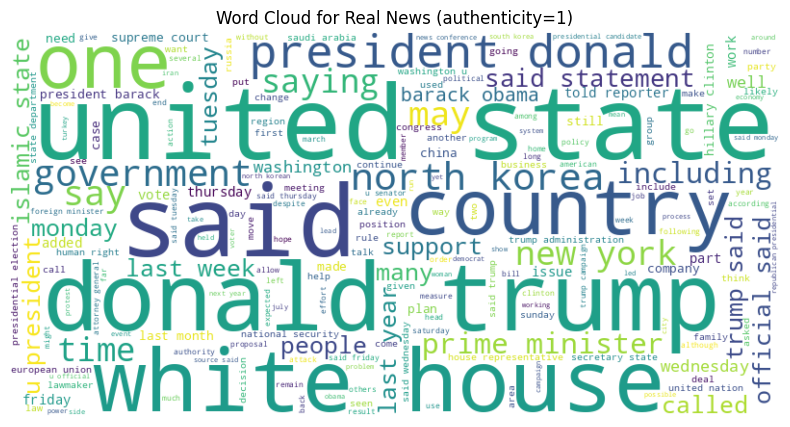

In [15]:
# Generate word cloud for real news
wordcloud_real = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(real_text)

# Plot the word cloud for real news
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News (authenticity=1)')
plt.show()

**Real News (authenticity = 1)**

Here, we see a more formal tone. Words like president, government, statement, country, and North Korea dominate. The appearance of specific days (e.g., Monday, Tuesday) and terms like prime minister, called, and support suggests a more factual and time-stamped style typical of traditional journalism.

Overall, while both types of articles focus on political figures and current events, fake news tends to rely more on vague or emotional language, whereas real news emphasizes official terms and detailed reporting.

### Word Count Distribution
To understand the variation in article lengths, let's group the texts into predefined word count ranges (e.g., 0–100, 101–300, etc.). This binning approach provides a clearer picture of how article lengths are distributed across the dataset.



/tmp/ipython-input-17-526196203.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_count_distribution.index, y=word_count_distribution.values, palette='viridis', legend=False)


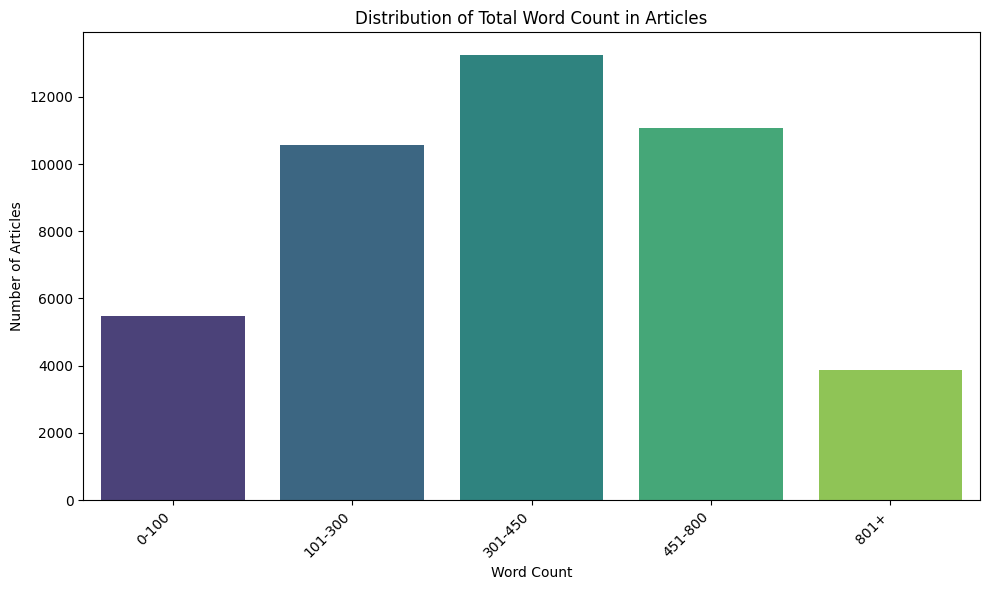

In [17]:
# Define the bins and labels for word count
bins = [0, 100, 300, 450, 800, float('inf')]
labels = ['0-100', '101-300', '301-450', '451-800', '801+']

# Create a new column 'word_count_bucket' by applying the bins to 'total_word_count'
df['word_count_bucket'] = pd.cut(df['total_word_count'], bins=bins, labels=labels, right=True)

# Count the occurrences in each bucket
word_count_distribution = df['word_count_bucket'].value_counts().sort_index()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=word_count_distribution.index, y=word_count_distribution.values, palette='viridis', legend=False)
plt.xlabel('Word Count Bucket')
plt.ylabel('Number of Articles')
plt.title('Distribution of Total Word Count in Articles')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Most articles fall between 301–450 words, making that the most common length. Articles in the 101–300 and 451–600 ranges also appear frequently, suggesting that the dataset is mostly made up of medium-length content.

Shorter articles (0–100 words) and long-form pieces (800+ words) are less common, while very long ones are relatively rare in standard news reporting.

This distribution is helpful to keep in mind when analyzing features like emotion or sentiment, suggesting that longer articles naturally contain more emotional or subjective language just due to word volume.

It makes sense that articles can have 100 words, however let's take a look whether there are any articles with less than 10, and drop these rows from the dataset to remove some outliers



In [18]:
df[df['total_word_count'] < 10]

,text,date,authenticity,text_clean,text_clean_spacey,text_polarity,text_subjectivity,emotion_word_count,total_word_count,anger,...,anticipation_normalized,disgust_normalized,fear_normalized,joy_normalized,negative_normalized,positive_normalized,sadness_normalized,surprise_normalized,trust_normalized,word_count_bucket
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,0,,,0.000000,0.000000,0,2,0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0-100
10923,,"May 10, 2017",0,,,0.000000,0.000000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11041,,"Apr 26, 2017",0,,,0.000000,0.000000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11117,Enjoy:,"Apr 17, 2017",0,enjoy,enjoy,0.400000,0.500000,4,1,0,...,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,0-100
11190,,"Apr 6, 2017",0,,,0.000000,0.000000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,,,0.000000,0.000000,0,2,0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0-100
21873,,"Apr 12, 2015",0,,,0.000000,0.000000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21882,You won t want to miss this,"Apr 9, 2015",0,want miss,win t want miss,0.000000,0.000000,0,7,0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0-100
21909,PRETTY FUNNY STUFF-MAKE SURE TO WATCH TO THE END.,"Apr 5, 2015",0,pretty funny stuffmake sure watch end,pretty funny stuffmake sure watch end,0.333333,0.962963,6,9,0,...,0.222222,0.0,0.111111,0.111111,0.0,0.111111,0.0,0.0,0.111111,0-100


In [19]:
df = df[df['total_word_count'] >= 10].copy()

# Reset the index of df after dropping rows to align with tfidf_df index
df.reset_index(drop=True, inplace=True)

print("\nDataFrame after dropping rows with less than 10 words:")
print(df.head())
print(df.tail())
df.info()


DataFrame after dropping rows with less than 10 words:
                                                text               date  \
0  Donald Trump just couldn t wish all Americans ...  December 31, 2017   
1  House Intelligence Committee Chairman Devin Nu...  December 31, 2017   
2  On Friday, it was revealed that former Milwauk...  December 30, 2017   
3  On Christmas day, Donald Trump announced that ...  December 29, 2017   
4  Pope Francis used his annual Christmas Day mes...  December 25, 2017   

   authenticity                                         text_clean  \
0             0  donald trump wish american happy new year leav...   
1             0  house intelligence committee chairman devin nu...   
2             0  friday revealed former milwaukee sheriff david...   
3             0  christmas day donald trump announced would bac...   
4             0  pope francis used annual christmas day message...   

                                   text_clean_spacey  text_polarity  \
0

### Emotion Features by Class
Let’s take a closer look at how different emotions show up in fake vs. real news articles.


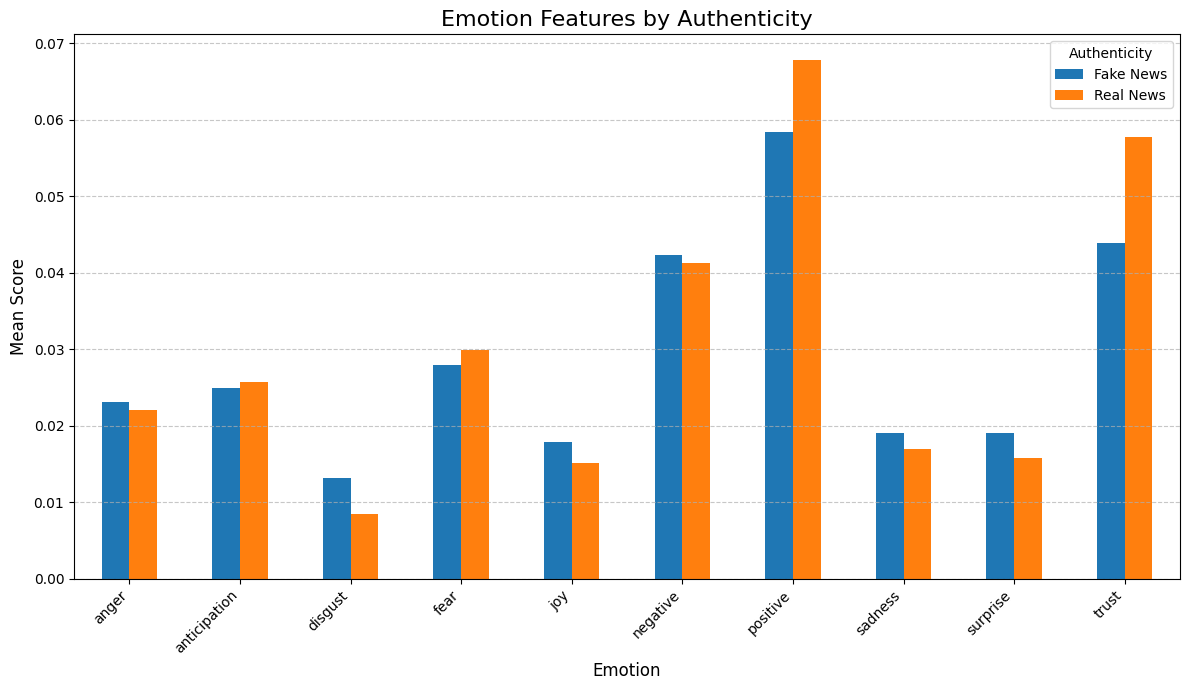

In [20]:
# Group by authenticity and calculate the mean of the normalized emotion features
emotion_by_authenticity = df.groupby('authenticity')[normalized_emotion_columns].mean()

# Transpose the dataframe for better plotting (emotions as rows, authenticity as columns)
emotion_by_authenticity_T = emotion_by_authenticity.T

# Rename the columns for clarity (0 -> Fake, 1 -> Real)
emotion_by_authenticity_T.rename(columns={0: 'Fake News', 1: 'Real News'}, inplace=True)

# Remove "_normalized" from the index names for clearer labels
emotion_by_authenticity_T.index = emotion_by_authenticity_T.index.str.replace('_normalized', '')

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
emotion_by_authenticity_T.plot(kind='bar', ax=ax)

plt.title('Emotion Features by Authenticity', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Mean Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Authenticity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

A few interesting takeaways:

- Positive emotions like trust and positive were slightly higher in real news, which may reflect more formal, informative, or confidence-building language.

- Fake news showed higher levels of disgust, surprise, and sadness, suggesting a tendency toward more emotionally provocative or dramatic language.

- Anger and fear were fairly common across both categories—possibly because political or crisis topics are central in both fake and real articles.

Overall, while both fake and real news convey emotion, real news tends to lean slightly more positive, while fake news dips more into the dramatic and negative spectrum.

### Sentiment Differences
Now, let’s take a look at how sentiment varies between fake and real news articles.

Analyzing sentiment helps reveal the underlying tone and intent of the content. It’s especially useful for spotting patterns as fake news may lean more emotional or opinionated, while real news might stick to a more neutral tone. Exploring these differences can offer valuable insights for detecting misinformation.



Average Sentiment Scores by Authenticity Class:
              text_polarity  text_subjectivity
authenticity                                  
0                  0.046236           0.435509
1                  0.042205           0.346565


Text(0, 0.5, 'Frequency')

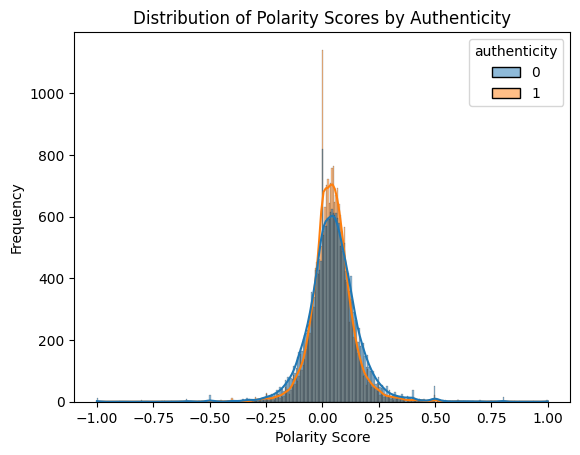

In [20]:
# Summarize average polarity and subjectivity scores by class
sentiment_summary = df.groupby('authenticity')[['text_polarity', 'text_subjectivity']].mean()
print("\nAverage Sentiment Scores by Authenticity Class:")
print(sentiment_summary)

# Polarity Distribution
sns.histplot(data=df, x='text_polarity', hue='authenticity',kde=True)
plt.title('Distribution of Polarity Scores by Authenticity')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')


**Distribution of Polarity Scores**

- Both fake and real news articles are heavily centered around zero, which represents neutral sentiment.

- The spike at 0 polarity is pronounced in both categories, with a slightly sharper spike in fake news.

- There's no significant skew toward either negative or positive polarity for either class.


It looks like both real and fake news use neutral sentiment language. The polarity score does not show a clear difference between fake and real news. This suggests polarity may not be a strong standalone indicator of news authenticity.

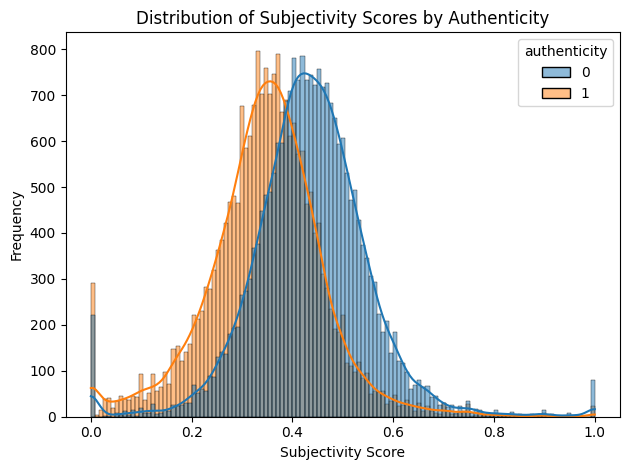

In [21]:
# Subjectivity Distribution
sns.histplot(data=df, x='text_subjectivity', hue='authenticity', kde=True)
plt.title('Distribution of Subjectivity Scores by Authenticity')
plt.xlabel('Subjectivity Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Distribution of Subjectivity Scores**

It looks like a clearer difference emerges here.

- Real news (orange) clusters more around lower subjectivity scores (~0.2 to 0.4).

- Fake news (blue) has a wider spread, with many articles showing higher subjectivity, extending beyond 0.6 and up to 1.0.

- There's also a visible spike near 0.0 for both, possibly due to short or purely factual statements.


This suggests that fake news tends to be more subjective, relying on opinionated or emotionally framed language. In contrast, real news tends to maintain a more objective tone, aligning with journalistic standards. This makes subjectivity a more promising feature for fake news detection than polarity.

## Model Evaluation
### Feature Selection


To further explore the relationship between emotional and sentiment characteristics and news authenticity, both independent T-tests and Mann-Whitney U tests are conducted to compare fake and real news articles across various features. Given that emotion and sentiment scores are not normally distributed, the Mann-Whitney U test served as the primary method, providing more robust non-parametric results. T-tests were also performed for reference, but interpretation prioritized the Mann-Whitney U findings.


In [22]:
from scipy.stats import ttest_ind, mannwhitneyu

# Separate data by authenticity
fake_news_df = df[df['authenticity'] == 0]
real_news_df = df[df['authenticity'] == 1]

# Define the columns to test
sentiment_columns = ['text_polarity', 'text_subjectivity']
emotion_columns = [f'{e}_normalized' for e in nrc_emotions]
columns_to_test = sentiment_columns + emotion_columns

print("\nPerforming Statistical Tests (T-test or Mann-Whitney U) for Sentiment and Emotion Scores by Authenticity:\n")

for col in columns_to_test:
    print(f"Testing column: {col}")

    # Extract the data for each group, dropping NaN values
    fake_data = fake_news_df[col].dropna()
    real_data = real_news_df[col].dropna()

    # Check if there is enough data in both groups
    if len(fake_data) < 2 or len(real_data) < 2:
        print(f"  Skipping {col}: Not enough data points in one or both groups.")
        continue

    # Perform T-test
    try:
        t_stat, p_value_t = ttest_ind(fake_data, real_data, equal_var=False, nan_policy='omit') # Welch's t-test (doesn't assume equal variance)
        print(f"  T-test results: t-statistic = {t_stat:.4f}, p-value = {p_value_t:.4f}")
    except Exception as e:
        print(f"  T-test failed for {col}: {e}")

    # Perform Mann-Whitney U test
    try:
        u_stat, p_value_mw = mannwhitneyu(fake_data, real_data, nan_policy='omit')
        print(f"  Mann-Whitney U test results: U-statistic = {u_stat:.4f}, p-value = {p_value_mw:.4f}")
    except Exception as e:
         print(f"  Mann-Whitney U test failed for {col}: {e}")

    print("-" * 30)

print("\nInterpretation Notes:")
print("- A low p-value (typically < 0.05) suggests a statistically significant difference between the two groups (Fake vs. Real).")
print("- T-test assumes approximate normality and equal variances (Welch's relaxes equal variances).")
print("- Mann-Whitney U test is a non-parametric test, suitable for non-normal data or when assumptions of T-test are not met.")
print("- Given the nature of emotion and sentiment scores, Mann-Whitney U is often a more robust choice.")
# ```


Performing Statistical Tests (T-test or Mann-Whitney U) for Sentiment and Emotion Scores by Authenticity:

Testing column: text_polarity
  T-test results: t-statistic = 3.9220, p-value = 0.0001
  Mann-Whitney U test results: U-statistic = 247890311.5000, p-value = 0.0000
------------------------------
Testing column: text_subjectivity
  T-test results: t-statistic = 78.8355, p-value = 0.0000
  Mann-Whitney U test results: U-statistic = 352986291.0000, p-value = 0.0000
------------------------------
Testing column: anger_normalized
  T-test results: t-statistic = 6.5983, p-value = 0.0000
  Mann-Whitney U test results: U-statistic = 256923281.5000, p-value = 0.0000
------------------------------
Testing column: anticipation_normalized
  T-test results: t-statistic = -5.8415, p-value = 0.0000
  Mann-Whitney U test results: U-statistic = 232892943.5000, p-value = 0.0000
------------------------------
Testing column: disgust_normalized
  T-test results: t-statistic = 49.8662, p-value = 0.0

**Key Findings:**

- Subjectivity shows a very strong difference between fake and real news (p < 0.001 in both tests), suggesting fake news is significantly more opinion-based.

- Polarity, which reflects the positive/negative tone of text, showed a significant difference using the T-test (p = 0.0053), though the Mann-Whitney U result was not below the 0.05 threshold. This suggests some differences in tone, though not as robust.

- Most emotion features (e.g., anger, fear, joy, sadness, disgust, trust) showed statistically significant differences with p-values well below 0.001 in both tests. This confirms that fake and real news evoke different emotional patterns.

- For example:

  - Fake news tends to have higher levels of disgust, anger, and fear.

  - Real news shows stronger signals in trust and positive emotions.



These results provide strong evidence that emotion and sentiment features differ significantly between fake and real news, making them useful indicators for classification tasks. The consistent results from the non-parametric Mann-Whitney U test further validate these differences, especially given that emotion scores tend to be non-normally distributed.


## Baseline Models using TF-IDF
To set up a baseline model, we used TF-IDF (Term Frequency–Inverse Document Frequency) to capture the importance of words in each article. This approach relies solely on the most important words in the text, without incorporating emotional or sentiment-based features. Both unigram (1,1) and bigram (1,2) configurations will be tested on the 3 models:

1.   Logistic Regression
2.   Random Forest
3.   Linear SVM


The top 100 features will be retained by setting `max_features=100` in the TF-IDF vectorizer. This limit was chosen to reduce computational load and runtime, while still capturing the most informative terms in the dataset. By focusing on the most frequent and relevant words, the model can be trained more efficiently without being overwhelmed by noise from less significant features.

All steps—TF-IDF vectorization and model training will be wrapped in a Pipeline to ensure that preprocessing is done only on the training data (avoiding data leakage).

By starting with this simpler representation, the effectiveness of more advanced models can be measured more clearly. If future models show significant improvement over this baseline, it would indicate that the additional features—such as emotion scores and sentiment polarity—contribute meaningful predictive value.


In [13]:
# import pandas as pd
# df = pd.read_csv('output_dataframe.csv')
# df.tail()

df_extracted = df.copy()

In [14]:

#Refresh the dataframe so it only includes cleaned text features
df = df_extracted[['text', 'text_clean', 'text_clean_spacey', 'authenticity']].copy()


In [15]:
# Display the head and info of the new DataFrame to verify
print(df.head())
df.info()

                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annual Christmas Day mes...   

                                          text_clean  \
0  donald trump wish american happy new year leav...   
1  house intelligence committee chairman devin nu...   
2  friday revealed former milwaukee sheriff david...   
3  christmas day donald trump announced would bac...   
4  pope francis used annual christmas day message...   

                                   text_clean_spacey  authenticity  
0  donald trump couldn t wish americans happy new...             0  
1  house intelligence committee chairman devin nu...             0  
2  friday reveal milwaukee sheriff david clarke c...             0  
3  christmas day donald trump announce work follo.

### Logistic Regression

In this section, we’re using Logistic Regression to establish this simple baseline model for fake news detection.

We’re using the `liblinear` solver for Logistic Regression. This solver is particularly effective for small to medium-sized datasets and works well with sparse feature spaces, which is exactly what we get from TF-IDF representations of text.


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time

def evaluate_model(model, model_name, ngram_label, ngram_range_val, X, y, max_features=100):
    """
    Train and evaluate a text classification model using TF-IDF + specified model.

    Parameters:
    - model: A scikit-learn classifier instance
    - model_name: A string for printing/logging
    - ngram_label: Description of n-gram config (e.g., 'Unigram')
    - ngram_range_val: Tuple for n-gram range (e.g., (1,1))
    - X: Text features (Series)
    - y: Labels
    - max_features: TF-IDF maximum features (default=100)
    """

    print(f"\nEvaluating {model_name} with {ngram_label} (ngram_range={ngram_range_val}, max_features={max_features})...\n")

    # Pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range_val)),
        ('clf', model)
    ])

    # Split (inside function to avoid leakage)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    start = time.time()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    end = time.time()

    print(f"Training + prediction time: {end - start:.2f} seconds")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy ({ngram_label}): {accuracy:.4f}")
    print(classification_report(y_test, y_pred))



In [36]:
from sklearn.linear_model import LogisticRegression
evaluate_model(LogisticRegression(solver='liblinear'), "Logistic Regression",
               "Unigram (1,1)", (1,1), df['text_clean'], df['authenticity'])
evaluate_model(LogisticRegression(solver='liblinear'), "Logistic Regression",
               "Bigram (1,2)", (1,2), df['text_clean'], df['authenticity'])



Evaluating Logistic Regression with Unigram (1,1) (ngram_range=(1, 1), max_features=100)...

Training + prediction time: 9.51 seconds
Logistic Regression accuracy (Unigram (1,1)): 0.9220
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4524
           1       0.91      0.93      0.92      4283

    accuracy                           0.92      8807
   macro avg       0.92      0.92      0.92      8807
weighted avg       0.92      0.92      0.92      8807


Evaluating Logistic Regression with Bigram (1,2) (ngram_range=(1, 2), max_features=100)...

Training + prediction time: 43.74 seconds
Logistic Regression accuracy (Bigram (1,2)): 0.9238
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4524
           1       0.91      0.93      0.92      4283

    accuracy                           0.92      8807
   macro avg       0.92      0.92      0.92      8807
weighted avg       0.92   

Confusion matrix returned similar scores with unigram

### Random Forest
In this step, we're training a Random Forest classifier.

We used 100 trees (n_estimators=100) in the Random Forest to strike a balance between model performance and runtime.

In [20]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42),
               "Random Forest", "Unigram (1,1)", (1,1), df['text_clean'], df['authenticity'])
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42),
               "Random Forest", "Bigram (1,2)", (1,2), df['text_clean'], df['authenticity'])


Evaluating Random Forest with Unigram (1,1) (ngram_range=(1, 1), max_features=100)...

Training + prediction time: 85.76 seconds
Random Forest accuracy (Unigram (1,1)): 0.9603
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4524
           1       0.96      0.95      0.96      4283

    accuracy                           0.96      8807
   macro avg       0.96      0.96      0.96      8807
weighted avg       0.96      0.96      0.96      8807


Evaluating Random Forest with Bigram (1,2) (ngram_range=(1, 2), max_features=100)...

Training + prediction time: 107.23 seconds
Random Forest accuracy (Bigram (1,2)): 0.9597
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4524
           1       0.96      0.95      0.96      4283

    accuracy                           0.96      8807
   macro avg       0.96      0.96      0.96      8807
weighted avg       0.96      0.96      0.96     

### Linear SVM
To complete our set of baseline models, we're using a Support Vector Machine (SVM) with a linear kernel (LinearSVC). This model works especially well with high-dimensional, sparse data—which makes it a great fit for TF-IDF features. It’s commonly used in text classification tasks and is known for its speed and strong performance on binary problems like fake vs. real news.




In [21]:
from sklearn.svm import LinearSVC

evaluate_model(LinearSVC(max_iter=1000), "Linear SVM",
               "Unigram (1,1)", (1,1), df['text_clean'], df['authenticity'])
evaluate_model(LinearSVC(max_iter=1000), "Linear SVM",
               "Bigram (1,2)", (1,2), df['text_clean'], df['authenticity'])



Evaluating Linear SVM with Unigram (1,1) (ngram_range=(1, 1), max_features=100)...

Training + prediction time: 11.05 seconds
Linear SVM accuracy (Unigram (1,1)): 0.9234
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4524
           1       0.91      0.93      0.92      4283

    accuracy                           0.92      8807
   macro avg       0.92      0.92      0.92      8807
weighted avg       0.92      0.92      0.92      8807


Evaluating Linear SVM with Bigram (1,2) (ngram_range=(1, 2), max_features=100)...

Training + prediction time: 45.57 seconds
Linear SVM accuracy (Bigram (1,2)): 0.9247
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4524
           1       0.91      0.93      0.92      4283

    accuracy                           0.92      8807
   macro avg       0.92      0.92      0.92      8807
weighted avg       0.92      0.92      0.92      8807



## Custom Transformers: Sentiment & Emotion Extraction
Before building models that incorporate emotional cues, we define two custom transformers: `SentimentExtractor` and `EmotionExtractor`. These are designed to work seamlessly within a Pipeline alongside TF-IDF features.

`SentimentExtractor` supports both TextBlob and VADER. It extracts two features: polarity (positive/negative tone) and subjectivity (opinion vs. fact).

`EmotionExtractor` uses the NRC Emotion Lexicon to calculate scores for 10 core emotions (e.g., joy, anger, fear) based on word frequencies in each text.

These transformers return structured numerical features that can be combined with traditional TF-IDF vectors to build richer, hybrid models that capture both the content and tone of each article.


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class SentimentExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sentiment_method="textblob"):
        """
        sentiment_method: "textblob" or "vader"
        """
        self.sentiment_method = sentiment_method
        if sentiment_method == "vader":
            from nltk.sentiment import SentimentIntensityAnalyzer
            self.vader = SentimentIntensityAnalyzer()
        else:
            self.vader = None

    def fit(self, X, y=None):
        return self

    def get_sentiment(self, text):
        if self.sentiment_method == "textblob":
            blob = TextBlob(text)
            return blob.sentiment.polarity, blob.sentiment.subjectivity
        elif self.sentiment_method == "vader":
            scores = self.vader.polarity_scores(text)
            # Return compound as polarity, subjectivity set to 0 (VADER does not provide subjectivity)
            return scores['compound'], 0.0
        else:
            raise ValueError(f"Unknown sentiment_method: {self.sentiment_method}")

    def transform(self, X):
        # If X is a DataFrame, select the first column
        if isinstance(X, pd.DataFrame):
            if X.shape[1] != 1:
                raise ValueError(f"Expected a single column for SentimentExtractor, got {X.shape[1]} columns.")
            X = X.iloc[:, 0]
        # If X is not a Series, convert it
        if not isinstance(X, pd.Series):
            X = pd.Series(X)

        features = []
        for text in X:
            polarity, subjectivity = self.get_sentiment(text)
            features.append({"polarity": polarity, "subjectivity": subjectivity})

        return pd.DataFrame(features).values


In [7]:

class EmotionExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nrc_emotions = [
            'anger', 'anticipation', 'disgust', 'fear', 'joy',
            'sadness', 'surprise', 'trust', 'positive', 'negative'
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # If X is a DataFrame, select the first column
        if isinstance(X, pd.DataFrame):
            if X.shape[1] != 1:
                raise ValueError(f"Expected a single column for SentimentExtractor, got {X.shape[1]} columns.")
            X = X.iloc[:, 0]
        # If X is not a Series, convert it
        if not isinstance(X, pd.Series):
            X = pd.Series(X)

        features = []
        for text in X:
            nrc = NRCLex(text)
            emotion_freqs = nrc.raw_emotion_scores
            total_emotion_words = sum(emotion_freqs.values()) or 1
            emotion_scores = {em: emotion_freqs.get(em, 0) / total_emotion_words for em in self.nrc_emotions}
            features.append(emotion_scores)

        return pd.DataFrame(features).values


Next, we build a `ColumnTransformer` that combines three types of inputs:

TF-IDF features (unigrams and bigrams, top 100 terms) extracted from the cleaned text.

Sentiment features (polarity and subjectivity), extracted using SentimentExtractor and scaled with StandardScaler.

Emotion features (10 NRC emotion scores), extracted using EmotionExtractor and also scaled.

By wrapping sentiment and emotion extractors in separate pipelines, we ensure that each set of features is properly extracted and standardized before being passed into the model. This setup allows us to blend both text content and emotional tone in a single, unified model pipeline.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Pipelines for extracting and scaling only the dense features
sentiment_pipe = Pipeline([
    ('extract', SentimentExtractor(sentiment_method="textblob")),
    ('scale', StandardScaler())
])

emotion_pipe = Pipeline([
    ('extract', EmotionExtractor()),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1,2)), 'text_clean'),
    ('sentiment', sentiment_pipe, 'text_clean'),
    ('emotion', emotion_pipe, 'text_clean'),
])


With the custom transformers and pipeline built, now let's build the proposed model



In [8]:
import time
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model_se(model, model_name, ngram_label, ngram_range_val,
                      X, y, text_col='text_clean',
                      max_features=100):
    """
    Evaluate a classifier using TF-IDF, sentiment, and emotion features.

    Parameters:
    - model: scikit-learn classifier instance (e.g., LogisticRegression())
    - model_name: Descriptive name for the classifier
    - ngram_label: Description string (e.g., "Unigram (1,1)")
    - ngram_range_val: N-gram range (tuple) for TF-IDF
    - X: Input DataFrame that includes the column specified by text_col
    - y: Labels (Series)
    - text_col: Name of the column in X to extract text from
    - max_features: Max number of TF-IDF features (default=100)
    """
    print(f"\nEvaluating {model_name} with {ngram_label}...\n")

    # Preprocessing pipeline (assumes sentiment_pipe and emotion_pipe are defined globally)
    preprocessor = ColumnTransformer(
        transformers=[
            ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range_val), text_col),
            ('sentiment', sentiment_pipe, text_col),
            ('emotion', emotion_pipe, text_col),
        ]
    )

    pipeline = Pipeline([
        ('features', preprocessor),
        ('clf', model)
    ])

    # Local train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    start = time.time()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    end = time.time()

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy ({ngram_label}): {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"Training + prediction time: {end - start:.2f} seconds")

    # Show feature importances if model is RandomForestClassifier
    if isinstance(model, RandomForestClassifier):
        show_rf_feature_importance(pipeline)

def show_rf_feature_importance(pipeline):
    """
    Extract and print top 15 feature importances from a fitted RandomForest pipeline.
    """
    rf_model = pipeline.named_steps['clf']
    fitted_preprocessor = pipeline.named_steps['features']

    tfidf_features = fitted_preprocessor.named_transformers_['tfidf'].get_feature_names_out()
    sentiment_features = ['polarity', 'subjectivity']
    emotion_features = [f"{e}_normalized" for e in ['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','positive','negative']]
    feature_names = list(tfidf_features) + sentiment_features + emotion_features

    importances = rf_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(importance_df.head(15).to_string(index=False))



Moving on to training and testing the models

### Logistic Regression with TF-IDF And Sentiment+Emotion Features
First, let's runs a Logistic Regression model

- Model: LogisticRegression with liblinear solver (suitable for small, sparse data) and max_iter=1000

- Features: TF-IDF (unigrams), sentiment (TextBlob), and NRC emotion scores

- Output: Test accuracy, classification report, and training time

This model serves as a strong baseline for comparison against more complex classifiers.

In [37]:
from sklearn.linear_model import LogisticRegression

evaluate_model_se(
    model=LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    model_name="Logistic Regression",
    ngram_label="Unigram (1,1)",
    ngram_range_val=(1,1),
    X=df[['text_clean']],
    y=df['authenticity'],
    text_col='text_clean'
)



Evaluating Logistic Regression with Unigram (1,1)...

Logistic Regression accuracy (Unigram (1,1)): 0.9259
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4524
           1       0.91      0.94      0.92      4283

    accuracy                           0.93      8807
   macro avg       0.93      0.93      0.93      8807
weighted avg       0.93      0.93      0.93      8807

Training + prediction time: 212.54 seconds


In [26]:
evaluate_model_se(
    model=LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    model_name="Logistic Regression",
    ngram_label="Bigram (1,2)",
    ngram_range_val=(1,2),
    X=df[['text_clean']],
    y=df['authenticity'],
    text_col='text_clean'
)


Evaluating Logistic Regression with Bigram (1,2)...

Logistic Regression accuracy (Bigram (1,2)): 0.9264
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4524
           1       0.91      0.94      0.93      4283

    accuracy                           0.93      8807
   macro avg       0.93      0.93      0.93      8807
weighted avg       0.93      0.93      0.93      8807

Training + prediction time: 270.76 seconds


### Random Forest with TF-IDF And Sentiment+Emotion Features

Next we evaluate using Random Forest classifier

- Model: RandomForestClassifier with 100 trees (n_estimators=100) and a fixed random_state for reproducibility

- Features: TF-IDF (unigrams), sentiment (TextBlob polarity & subjectivity), and NRC emotion scores

- Output: Accuracy, classification report, training time, and top 15 most important features based on model interpretation

This helps assess not only performance but also feature contribution, offering insight into what drives the model’s predictions.

In [38]:
from sklearn.ensemble import RandomForestClassifier

evaluate_model_se(
    model=RandomForestClassifier(n_estimators=100, random_state=42),
    model_name="Random Forest",
    ngram_label="Unigram (1,1)",
    ngram_range_val=(1, 1),
    X=df[['text_clean']],
    y=df['authenticity'],
    text_col='text_clean'
)



Evaluating Random Forest with Unigram (1,1)...

Random Forest accuracy (Unigram (1,1)): 0.9605
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4524
           1       0.96      0.95      0.96      4283

    accuracy                           0.96      8807
   macro avg       0.96      0.96      0.96      8807
weighted avg       0.96      0.96      0.96      8807

Training + prediction time: 238.87 seconds

Top 15 Most Important Features:
           Feature  Importance
              said    0.187722
               via    0.087571
             image    0.063099
              like    0.034851
        washington    0.033916
              know    0.024052
           hillary    0.023268
  trust_normalized    0.022331
disgust_normalized    0.021467
        government    0.019363
           america    0.017493
              even    0.013100
               get    0.012936
          american    0.012601
             obama    0.011965


In [30]:
evaluate_model_se(
    model=RandomForestClassifier(n_estimators=100, random_state=42),
    model_name="Random Forest",
    ngram_label="Bigram (1,2)",
    ngram_range_val=(1, 2),
    X=df[['text_clean']],
    y=df['authenticity'],
    text_col='text_clean'
)



Evaluating Random Forest with Bigram (1,2)...

Random Forest accuracy (Bigram (1,2)): 0.9606
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4524
           1       0.97      0.95      0.96      4283

    accuracy                           0.96      8807
   macro avg       0.96      0.96      0.96      8807
weighted avg       0.96      0.96      0.96      8807

Training + prediction time: 314.29 seconds

Top 15 Most Important Features:
           Feature  Importance
              said    0.194433
               via    0.078000
             image    0.060548
        washington    0.034187
              like    0.033813
  trust_normalized    0.024094
              know    0.022744
           hillary    0.021188
disgust_normalized    0.020679
        government    0.020622
           america    0.018787
               get    0.015824
              even    0.014670
             obama    0.012630
          american    0.012411


### SVM with TF-IDF and Sentiment + Emotion Features
This cell runs a Linear Support Vector Machine (SVM) classifier using unigram-based TF-IDF features, combined with sentiment and emotion inputs. The model is evaluated using the evaluate_model_se() function, which handles preprocessing, training, and reporting.

- Model: LinearSVC with max_iter=1000 and a fixed random_state for reproducibility

- Features: TF-IDF (unigrams), sentiment (polarity & subjectivity), and 10 NRC emotion scores

- Output: Accuracy, classification report, and training time on a held-out test split

This setup contributes to the final comparison of hybrid models and supports clear interpretation of performance with consistent preprocessing.

In [42]:
from sklearn.svm import LinearSVC

# Evaluate Linear SVM with unigram features
evaluate_model_se(
    model=LinearSVC(random_state=42, max_iter=1000),
    model_name="Linear SVM",
    ngram_label="Unigram (1,1)",
    ngram_range_val=(1, 1),
    X=df[['text_clean']],
    y=df['authenticity'],
    text_col='text_clean'
)



Evaluating Linear SVM with Unigram (1,1)...

Linear SVM accuracy (Unigram (1,1)): 0.9299
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4524
           1       0.92      0.94      0.93      4283

    accuracy                           0.93      8807
   macro avg       0.93      0.93      0.93      8807
weighted avg       0.93      0.93      0.93      8807

Training + prediction time: 141.53 seconds


Now with bigram features

In [43]:
# Evaluate with bigram features
evaluate_model_se(
    model=LinearSVC(random_state=42, max_iter=1000),
    model_name="Linear SVM",
    ngram_label="Bigram (1,2)",
    ngram_range_val=(1, 2),
    X=df[['text_clean']],
    y=df['authenticity'],
    text_col='text_clean'
)


Evaluating Linear SVM with Bigram (1,2)...

Linear SVM accuracy (Bigram (1,2)): 0.9298
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4524
           1       0.92      0.94      0.93      4283

    accuracy                           0.93      8807
   macro avg       0.93      0.93      0.93      8807
weighted avg       0.93      0.93      0.93      8807

Training + prediction time: 180.07 seconds


## Cross-Validation

This section prepares the components needed to perform 5-fold stratified cross-validation using three classifiers:

- Random Forest

- Logistic Regression

- Linear SVM

Each model is evaluated using a consistent preprocessing pipeline that combines:

- TF-IDF features (unigrams, top 100 terms)

- Sentiment features (polarity & subjectivity from TextBlob)

- Emotion features (normalized NRC scores)

The ColumnTransformer ensures all features are extracted and scaled properly within each fold. The use of StratifiedKFold ensures that class proportions are maintained across splits, supporting robust and fair performance comparisons.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# Preprocessing pipeline setup
sentiment_pipe = Pipeline([
    ('extract', SentimentExtractor(sentiment_method="textblob")),
    ('scale', StandardScaler())
])
emotion_pipe = Pipeline([
    ('extract', EmotionExtractor()),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1,1)), 'text_clean'),
    ('sentiment', sentiment_pipe, 'text_clean'),
    ('emotion', emotion_pipe, 'text_clean'),
])

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
    "Linear SVM": LinearSVC(random_state=42, max_iter=1000)
}

# Prepare data (ensure DataFrame for ColumnTransformer)
X = df[['text_clean']]
y = df['authenticity']

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

This loop performs 5-fold cross-validation for each model (Random Forest, Logistic Regression, and Linear SVM) using the hybrid feature pipeline. For each fold:

- Train and test accuracy, as well as macro F1 scores, are recorded.

- Misclassified examples are stored with true and predicted labels for further error analysis.

- Training vs. test accuracy gap is computed to flag potential overfitting.

After all folds:

- Average performance metrics are printed.

- Misclassified samples are aggregated across all folds into all_misclassified.

- A warning will be shown if the training-test accuracy gap exceeds 5%, indicating potential overfitting.

This provides a detailed view of each model’s generalization ability and highlights areas for performance improvement.

In [41]:
# Initialize an empty DataFrame to store misclassified examples
all_misclassified = pd.DataFrame()

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    train_accuracies = []
    test_accuracies = []
    f1s = []
    misclassified_examples = []  # temporary list for this model

    start = time.time()

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ('features', preprocessor),
            ('clf', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred_test = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)

        test_acc = accuracy_score(y_test, y_pred_test)
        train_acc = accuracy_score(y_train, y_pred_train)
        f1 = f1_score(y_test, y_pred_test, average='macro')

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        f1s.append(f1)

        print(f"  Fold {fold} Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | F1 (macro): {f1:.4f}")

        # Collect misclassified samples for the current fold
        misclassified_mask = y_test != y_pred_test
        fold_misclassified = pd.DataFrame({
            'text': X_test.loc[misclassified_mask, 'text_clean'].values, # Use .loc and .values
            'true_label': y_test[misclassified_mask].values,
            'predicted_label': y_pred_test[misclassified_mask]
        })
        fold_misclassified['model'] = model_name
        fold_misclassified['fold'] = fold
        misclassified_examples.append(fold_misclassified)

    # Combine all misclassified from this model
    model_misclassified_df = pd.concat(misclassified_examples, ignore_index=True)
    all_misclassified = pd.concat([all_misclassified, model_misclassified_df], ignore_index=True)

    avg_train_acc = np.mean(train_accuracies)
    avg_test_acc = np.mean(test_accuracies)
    avg_f1 = np.mean(f1s)
    gap = avg_train_acc - avg_test_acc

    print(f"Average Train Accuracy: {avg_train_acc:.4f}")
    print(f"Average Test Accuracy: {avg_test_acc:.4f}")
    print(f"Accuracy Gap (Train - Test): {gap:.4f}")
    print(f"Average F1 (macro): {avg_f1:.4f} ± {np.std(f1s):.4f}")

    end = time.time()
    print(f"Cross Validation run time: {end - start:.2f} seconds")

    if gap > 0.05:
        print("⚠️  Warning: Potential overfitting detected.")
    else:
        print("✅  No strong signs of overfitting.")


--- Random Forest ---
  Fold 1 Train Acc: 1.0000 | Test Acc: 0.9625 | F1 (macro): 0.9625
  Fold 2 Train Acc: 1.0000 | Test Acc: 0.9633 | F1 (macro): 0.9633
  Fold 3 Train Acc: 1.0000 | Test Acc: 0.9640 | F1 (macro): 0.9640
  Fold 4 Train Acc: 1.0000 | Test Acc: 0.9631 | F1 (macro): 0.9631
  Fold 5 Train Acc: 1.0000 | Test Acc: 0.9607 | F1 (macro): 0.9607
Average Train Accuracy: 1.0000
Average Test Accuracy: 0.9627
Accuracy Gap (Train - Test): 0.0373
Average F1 (macro): 0.9627 ± 0.0011
✅  No strong signs of overfitting.

--- Logistic Regression ---
  Fold 1 Train Acc: 0.9299 | Test Acc: 0.9285 | F1 (macro): 0.9284
  Fold 2 Train Acc: 0.9290 | Test Acc: 0.9304 | F1 (macro): 0.9304
  Fold 3 Train Acc: 0.9298 | Test Acc: 0.9278 | F1 (macro): 0.9278
  Fold 4 Train Acc: 0.9309 | Test Acc: 0.9275 | F1 (macro): 0.9275
  Fold 5 Train Acc: 0.9304 | Test Acc: 0.9266 | F1 (macro): 0.9266
Average Train Accuracy: 0.9300
Average Test Accuracy: 0.9282
Accuracy Gap (Train - Test): 0.0018
Average F1 (m

### Further Visualizations

In [99]:
model_results = pd.read_csv('model_results.csv')
model_results.head()

,Model,Feature Configuration,Accuracy,F1 (Macro),Training Time
0,Logistic Regression,TF-IDF (Unigram),0.9220,0.92,9.51
1,Logistic Regression,TF-IDF (Bigram),0.9238,0.92,43.74
2,Logistic Regression,Combined Features (Unigram),0.9259,0.93,212.54
3,Logistic Regression,Combined Features (Bigram),0.9264,0.93,270.76
4,Random Forest,TF-IDF (Unigram),0.9603,0.96,85.76


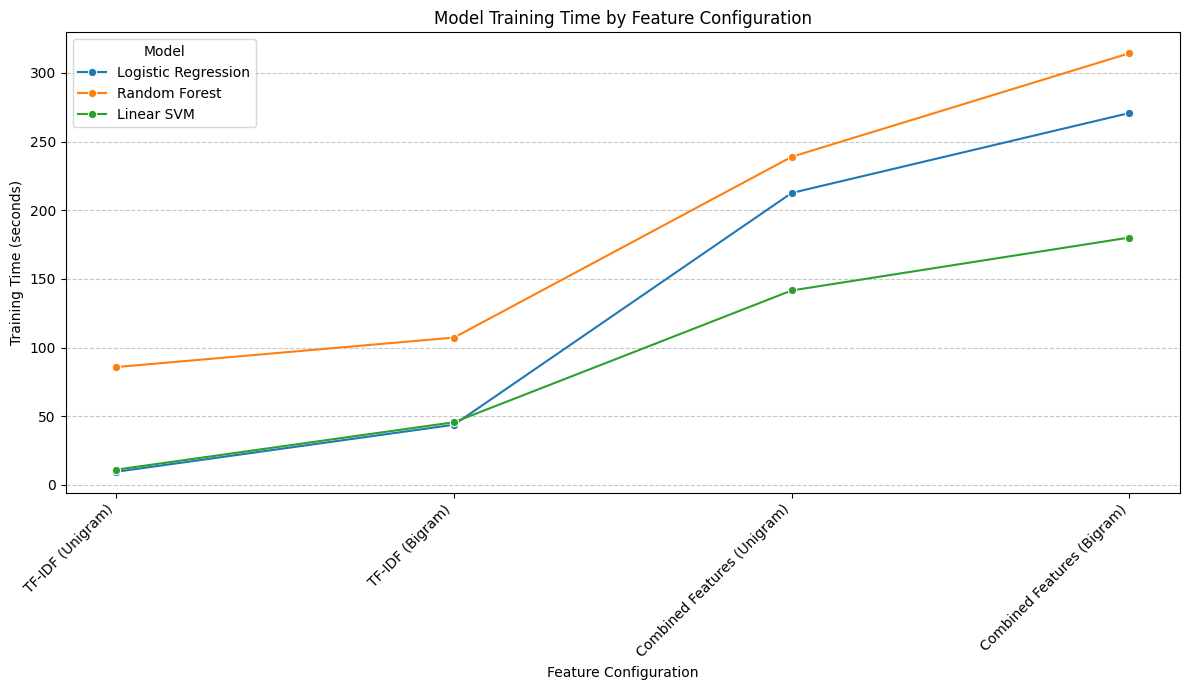

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define a logical order for configurations for the line plot
# This order goes from simpler features to more complex
config_order = [
    'TF-IDF (Unigram)',
    'TF-IDF (Bigram)',
    'Combined Features (Unigram)',
    'Combined Features (Bigram)'
]

# Ensure the Configuration column is a categorical type with the defined order
model_results['Feature Configuration'] = pd.Categorical(model_results['Feature Configuration'],categories=config_order, ordered=True)

# Create a line plot to visualize training time by configuration and model
plt.figure(figsize=(12, 7))
sns.lineplot(x='Feature Configuration', y='Training Time', hue='Model', data=model_results, marker='o') # Added marker='o' to show points

plt.title('Model Training Time by Feature Configuration')
plt.xlabel('Feature Configuration')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add grid for better readability
plt.tight_layout()
plt.show()

/tmp/ipython-input-103-1005284260.py:21: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


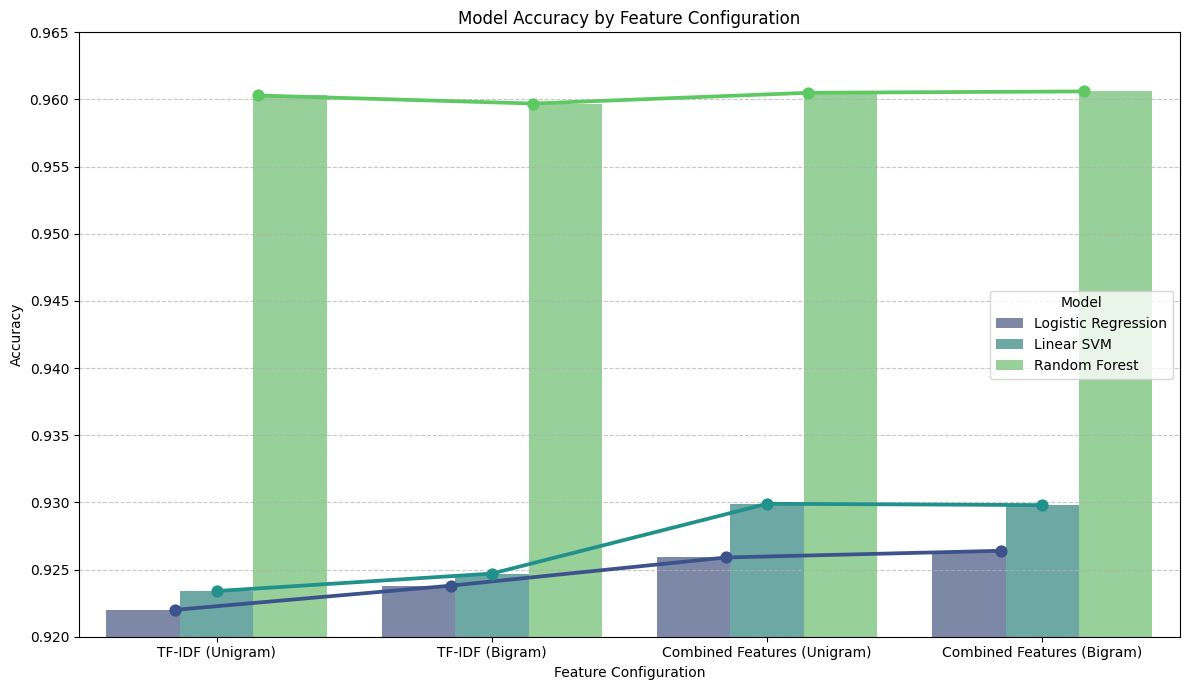

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set model order
model_order = ['Logistic Regression', 'Linear SVM', 'Random Forest']
model_results['Model'] = pd.Categorical(model_results['Model'], categories=model_order, ordered=True)

plt.figure(figsize=(12, 7))

# Barplot
sns.barplot(
    x='Feature Configuration',
    y='Accuracy',
    hue='Model',
    data=model_results,
    palette='viridis',
    alpha=0.7
)

# Overlay pointplot (aligned with barplot)
sns.pointplot(
    x='Feature Configuration',
    y='Accuracy',
    hue='Model',
    data=model_results,
    markers='o',
    dodge=0.3,     # Align with bar positions
    join=True,
    errorbar=None, # Turn off CI error bars if not needed
    palette='viridis',
    legend=False
)

plt.title('Model Accuracy by Feature Configuration')
plt.xlabel('Feature Configuration')
plt.ylabel('Accuracy')
plt.ylim(0.92, 0.965)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


/tmp/ipython-input-119-759044857.py:19: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


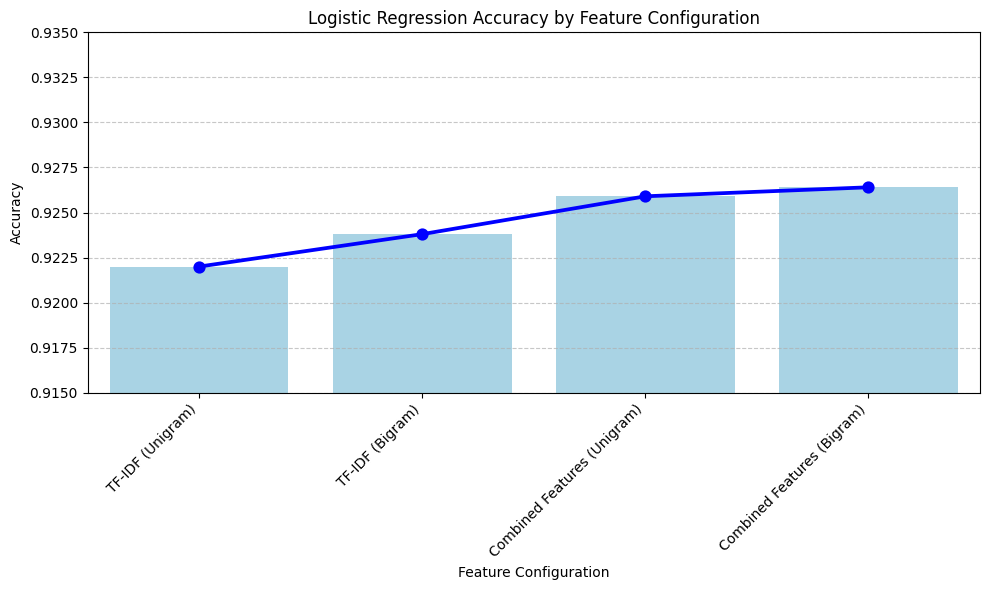

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to Random Forest only
rf_results = model_results[model_results['Model'] == 'Logistic Regression']

plt.figure(figsize=(10, 6))

# Barplot for RF
sns.barplot(
    x='Feature Configuration',
    y='Accuracy',
    data=rf_results,
    color='skyblue',
    alpha=0.8
)

# Add pointplot trend line
sns.pointplot(
    x='Feature Configuration',
    y='Accuracy',
    data=rf_results,
    color='blue',
    marker='o',
    join=True,
    errorbar=None
)

plt.title('Logistic Regression Accuracy by Feature Configuration')
plt.xlabel('Feature Configuration')
plt.ylabel('Accuracy')
plt.ylim(0.915, 0.935)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/tmp/ipython-input-110-3204718417.py:19: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


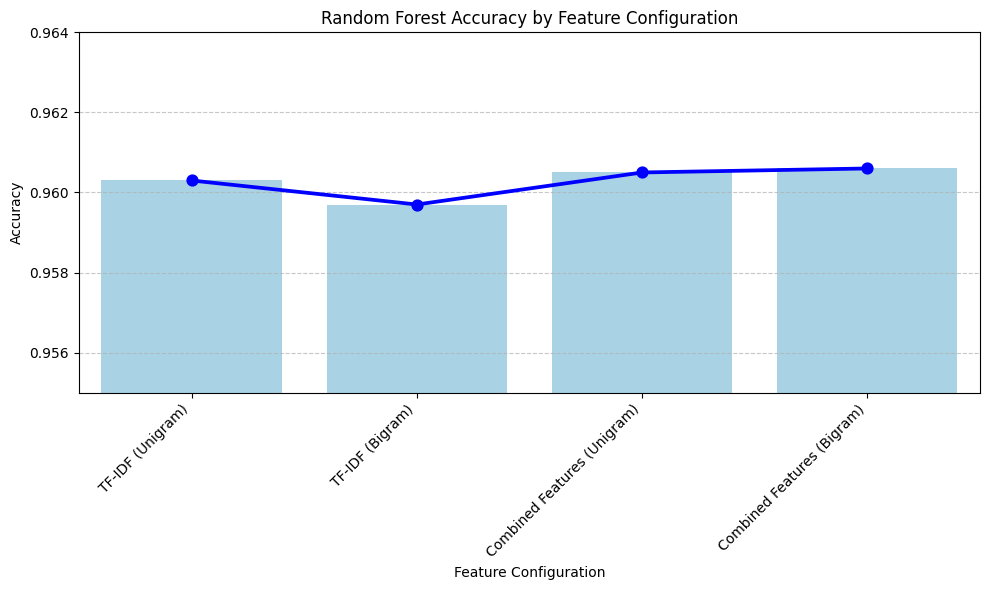

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to Random Forest only
rf_results = model_results[model_results['Model'] == 'Random Forest']

plt.figure(figsize=(10, 6))

# Barplot for RF
sns.barplot(
    x='Feature Configuration',
    y='Accuracy',
    data=rf_results,
    color='skyblue',
    alpha=0.8
)

# Add pointplot trend line
sns.pointplot(
    x='Feature Configuration',
    y='Accuracy',
    data=rf_results,
    color='blue',
    marker='o',
    join=True,
    errorbar=None
)

plt.title('Random Forest Accuracy by Feature Configuration')
plt.xlabel('Feature Configuration')
plt.ylabel('Accuracy')
plt.ylim(0.955, 0.964)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/tmp/ipython-input-117-941414196.py:19: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


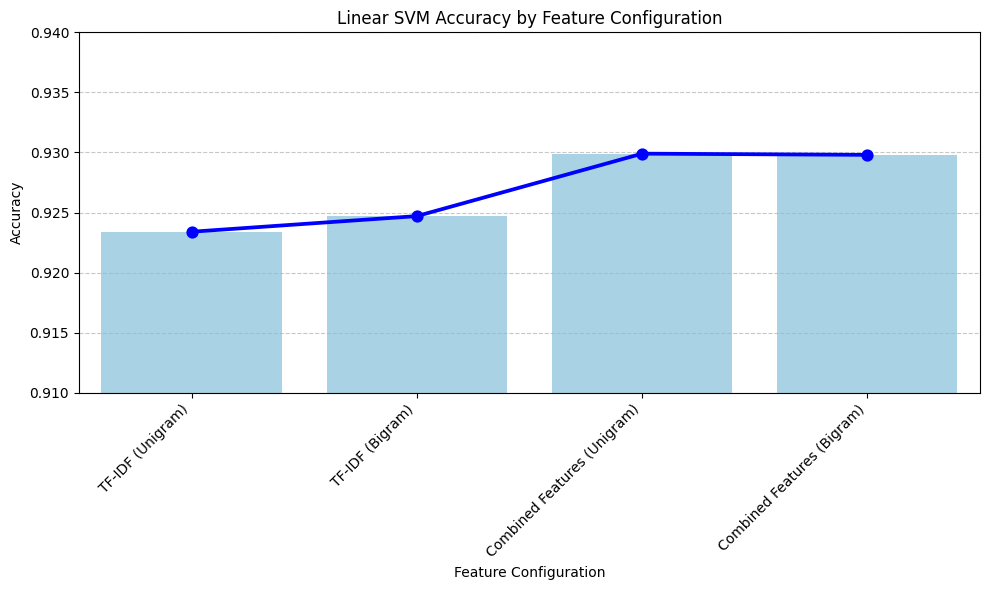

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to Random Forest only
rf_results = model_results[model_results['Model'] == 'Linear SVM']

plt.figure(figsize=(10, 6))

# Barplot for RF
sns.barplot(
    x='Feature Configuration',
    y='Accuracy',
    data=rf_results,
    color='skyblue',
    alpha=0.8
)

# Add pointplot trend line
sns.pointplot(
    x='Feature Configuration',
    y='Accuracy',
    data=rf_results,
    color='blue',
    marker='o',
    join=True,
    errorbar=None
)

plt.title('Linear SVM Accuracy by Feature Configuration')
plt.xlabel('Feature Configuration')
plt.ylabel('Accuracy')
plt.ylim(0.915, 0.935)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


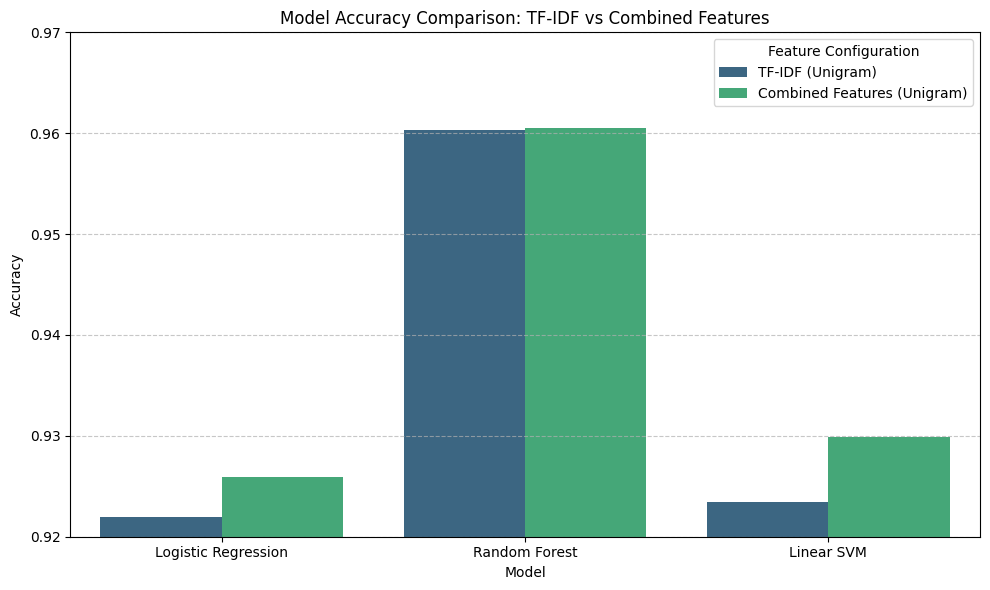

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# model_results = pd.read_csv('model_results.csv')
# model_results.head()

# Filter model_results for unigram TF-IDF and Combined Features (Unigram) configurations
unigram_comparison_results = model_results[
    model_results['Feature Configuration'].isin(['TF-IDF (Unigram)', 'Combined Features (Unigram)'])
]

# Create the grouped bar plot, using Configuration as hue
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', hue='Feature Configuration', data=unigram_comparison_results, palette='viridis')

plt.title('Model Accuracy Comparison: TF-IDF vs Combined Features')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.92, .97) # Set y-axis limits for better visualization of differences
plt.legend(title='Feature Configuration')
plt.tight_layout()
plt.show()

### Exploring Misclassifications

In [57]:

# Sentiment
all_misclassified[['text_polarity', 'text_subjectivity']] = all_misclassified['text'].apply(lambda x: pd.Series(get_sentiment(x)))

all_misclassified['emotion_word_count'] = all_misclassified['text'].apply(count_emotion_words)
all_misclassified['total_word_count'] = all_misclassified['text'].apply(count_total_words)

# Emotions: one column per emotion
text_emotion_df = all_misclassified['text'].apply(lambda x: pd.Series(get_emotion_vector(x), index=[f"{e}" for e in nrc_emotions]))


# Combine with original DataFrame
all_misclassified = pd.concat([all_misclassified, text_emotion_df], axis=1)
all_misclassified.tail()


,text,true_label,predicted_label,model,fold,text_polarity,text_subjectivity,emotion_word_count,total_word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
7907,amsterdam hurricane irma caused enormous devas...,1,0,Linear SVM,5,-0.030357,0.227976,55,131,2,7,1,7,2,5,13,5,4,9
7908,bogota pope francis arrived fiveday trip colom...,1,0,Linear SVM,5,-0.300000,0.500000,29,41,1,3,0,3,3,2,7,0,3,7
7909,rome pope francis flew italy wednesday headed ...,1,0,Linear SVM,5,0.045370,0.337963,38,76,4,4,1,6,3,7,4,1,1,7
7910,caracas laughing tribulation venezuelan theate...,1,0,Linear SVM,5,0.070050,0.333687,122,226,12,7,9,19,5,26,20,10,3,11
7911,london prince william harry paid quiet tribute...,1,0,Linear SVM,5,0.078532,0.418096,193,290,10,25,8,10,21,21,49,20,11,18


In [66]:
# Example: Fake predicted as Real
mask = (all_misclassified['true_label'] == 1) & (all_misclassified['predicted_label'] == 0)
fake_as_real = all_misclassified[mask]

<class 'pandas.core.frame.DataFrame'>
Index: 3563 entries, 132 to 7911
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                3563 non-null   object 
 1   true_label          3563 non-null   int64  
 2   predicted_label     3563 non-null   int64  
 3   model               3563 non-null   object 
 4   fold                3563 non-null   int64  
 5   text_polarity       3563 non-null   float64
 6   text_subjectivity   3563 non-null   float64
 7   emotion_word_count  3563 non-null   int64  
 8   total_word_count    3563 non-null   int64  
 9   anger               3563 non-null   int64  
 10  anticipation        3563 non-null   int64  
 11  disgust             3563 non-null   int64  
 12  fear                3563 non-null   int64  
 13  joy                 3563 non-null   int64  
 14  negative            3563 non-null   int64  
 15  positive            3563 non-null   int64  
 16  sadness  

In [ ]:
# Define the bins and labels for word count
bins = [0, 100, 300, 450, 800, float('inf')]
labels = ['0-100', '101-300', '301-450', '451-800', '801+']

# Create a new column 'word_count_bucket' by applying the bins to 'total_word_count'
df['word_count_bucket'] = pd.cut(df['total_word_count'], bins=bins, labels=labels, right=True)

# Count the occurrences in each bucket
word_count_distribution = df['word_count_bucket'].value_counts().sort_index()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=word_count_distribution.index, y=word_count_distribution.values, palette='viridis', legend=False)
plt.xlabel('Word Count Bucket')
plt.ylabel('Number of Articles')
plt.title('Distribution of Total Word Count in Articles')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [67]:
# Save the all_misclassified DataFrame to a CSV file
all_misclassified.to_csv('misclassified_examples.csv', index=False)

print("Misclassified examples saved to misclassified_examples.csv")

Misclassified examples saved to misclassified_examples.csv


In [60]:
all_misclassified.sample(5)


,text,true_label,predicted_label,model,fold,text_polarity,text_subjectivity,emotion_word_count,total_word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
1856,nuclear industry necessity energy production d...,0,1,Logistic Regression,1,-0.029667,0.402333,153,325,6,15,3,7,11,12,50,9,8,32
3774,please pray victim family least people killed ...,0,1,Logistic Regression,4,-0.114414,0.368694,171,239,19,18,3,31,9,27,21,14,8,21
328,helsinki finnish police thursday released one ...,1,0,Random Forest,1,0.045833,0.366667,52,72,6,2,2,11,0,14,7,4,0,6
4413,source tell utahpolicycom former massachusetts...,0,1,Logistic Regression,5,0.128704,0.393056,39,136,1,5,0,0,3,2,12,1,2,13
3837,girl gender suffer embarrassment humiliation e...,0,1,Logistic Regression,4,0.037406,0.403195,95,246,2,10,6,5,4,16,22,7,1,22


In [58]:
conf_matrix = pd.crosstab(all_misclassified['true_label'], all_misclassified['predicted_label'])
print(conf_matrix)

predicted_label     0     1
true_label                 
0                   0  4349
1                3563     0


In [59]:
all_misclassified.groupby('model').size().sort_values(ascending=False)


,0
model,
Logistic Regression,3163
Linear SVM,3108
Random Forest,1641


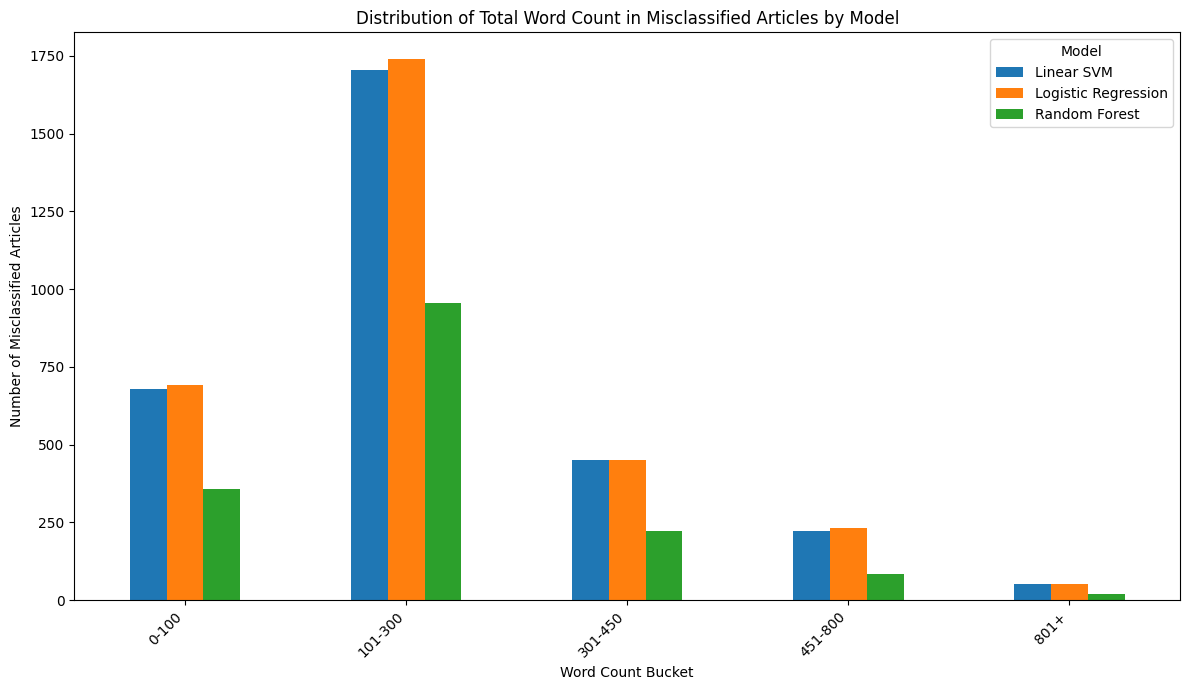

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

# Define the bins and labels for word count
bins = [0, 100, 300, 450, 800, float('inf')]
labels = ['0-100', '101-300', '301-450', '451-800', '801+']

# Create a new column 'word_count_bucket' by applying the bins to 'total_word_count' in all_misclassified
# Ensure 'total_word_count' exists in all_misclassified, if not, re-calculate it
if 'total_word_count' not in all_misclassified.columns:
     # Assuming 'text' column exists in all_misclassified
     all_misclassified['total_word_count'] = all_misclassified['text'].apply(lambda x: len(str(x).split()))


all_misclassified['word_count_bucket'] = pd.cut(all_misclassified['total_word_count'], bins=bins, labels=labels, right=True)


# Group by model and then count the occurrences in each bucket
word_count_distribution_by_model = all_misclassified.groupby('model')['word_count_bucket'].value_counts().unstack(fill_value=0)

# Ensure all labels are present as columns for consistent plotting
word_count_distribution_by_model = word_count_distribution_by_model.reindex(columns=labels, fill_value=0)

# Transpose the DataFrame for plotting with models as legend
word_count_distribution_by_model_T = word_count_distribution_by_model.T

# Plotting the bar graphs with word count buckets on x-axis and models as legend
word_count_distribution_by_model_T.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Word Count Bucket')
plt.ylabel('Number of Misclassified Articles')
plt.title('Distribution of Total Word Count in Misclassified Articles by Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

### Further Comparisons with alternative approaches

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Preprocessing pipeline setup
sentiment_pipe = Pipeline([
    ('extract', SentimentExtractor(sentiment_method="vader")),
    ('scale', StandardScaler())
])
emotion_pipe = Pipeline([
    ('extract', EmotionExtractor()),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1,1)), 'text_clean'),
    ('sentiment', sentiment_pipe, 'text_clean'),
    ('emotion', emotion_pipe, 'text_clean'),
])

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
    "Linear SVM": LinearSVC(random_state=42, max_iter=1000)
}

# Prepare data (ensure DataFrame for ColumnTransformer)
X = df[['text_clean']]
y = df['authenticity']

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty DataFrame to store misclassified examples
all_misclassified = pd.DataFrame()

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    accuracies = []
    f1s = []
    misclassified_examples = []  # temporary list for this model

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ('features', preprocessor),
            ('clf', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracies.append(acc)
        f1s.append(f1)
        print(f"  Fold {fold} Accuracy: {acc:.4f} | F1 (macro): {f1:.4f}")

        # Collect misclassified samples
        misclassified_mask = y_test != y_pred
        fold_misclassified = pd.DataFrame({
            'text': X_test[misclassified_mask]['text_clean'],
            'true_label': y_test[misclassified_mask].values,
            'predicted_label': y_pred[misclassified_mask]
        })
        fold_misclassified['model'] = model_name
        fold_misclassified['fold'] = fold
        misclassified_examples.append(fold_misclassified)

    # Combine all misclassified from this model
    model_misclassified_df = pd.concat(misclassified_examples, ignore_index=True)
    all_misclassified = pd.concat([all_misclassified, model_misclassified_df], ignore_index=True)

    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    print(f"Average Accuracy: {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"Average F1 (macro): {avg_f1:.4f} ± {std_f1:.4f}")



--- Random Forest ---
  Fold 1 Accuracy: 0.9608 | F1 (macro): 0.9608
  Fold 2 Accuracy: 0.9625 | F1 (macro): 0.9625
  Fold 3 Accuracy: 0.9634 | F1 (macro): 0.9634
  Fold 4 Accuracy: 0.9638 | F1 (macro): 0.9637
  Fold 5 Accuracy: 0.9582 | F1 (macro): 0.9582
Average Accuracy: 0.9618 ± 0.0020
Average F1 (macro): 0.9617 ± 0.0020

--- Logistic Regression ---
  Fold 1 Accuracy: 0.9266 | F1 (macro): 0.9266
  Fold 2 Accuracy: 0.9314 | F1 (macro): 0.9314
  Fold 3 Accuracy: 0.9254 | F1 (macro): 0.9254
  Fold 4 Accuracy: 0.9265 | F1 (macro): 0.9265
  Fold 5 Accuracy: 0.9232 | F1 (macro): 0.9232
Average Accuracy: 0.9266 ± 0.0027
Average F1 (macro): 0.9266 ± 0.0027

--- Linear SVM ---
  Fold 1 Accuracy: 0.9278 | F1 (macro): 0.9278
  Fold 2 Accuracy: 0.9310 | F1 (macro): 0.9309
  Fold 3 Accuracy: 0.9246 | F1 (macro): 0.9246
  Fold 4 Accuracy: 0.9268 | F1 (macro): 0.9267
  Fold 5 Accuracy: 0.9243 | F1 (macro): 0.9242
Average Accuracy: 0.9269 ± 0.0024
Average F1 (macro): 0.9269 ± 0.0024


In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Preprocessing pipeline setup
sentiment_pipe = Pipeline([
    ('extract', SentimentExtractor(sentiment_method="textblob")),
    ('scale', StandardScaler())
])
emotion_pipe = Pipeline([
    ('extract', EmotionExtractor()),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1,1)), 'text_clean_spacey'),
    ('sentiment', sentiment_pipe, 'text_clean_spacey'),
    ('emotion', emotion_pipe, 'text_clean_spacey'),
])

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
    "Linear SVM": LinearSVC(random_state=42, max_iter=1000)
}

# Prepare data (ensure DataFrame for ColumnTransformer)
X = df[['text_clean_spacey']]
y = df['authenticity']

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty DataFrame to store misclassified examples
all_misclassified = pd.DataFrame()

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    accuracies = []
    f1s = []
    misclassified_examples = []  # temporary list for this model

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ('features', preprocessor),
            ('clf', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracies.append(acc)
        f1s.append(f1)
        print(f"  Fold {fold} Accuracy: {acc:.4f} | F1 (macro): {f1:.4f}")

        # Collect misclassified samples
        misclassified_mask = y_test != y_pred
        fold_misclassified = pd.DataFrame({
            'text': X_test[misclassified_mask]['text_clean_spacey'],
            'true_label': y_test[misclassified_mask].values,
            'predicted_label': y_pred[misclassified_mask]
        })
        fold_misclassified['model'] = model_name
        fold_misclassified['fold'] = fold
        misclassified_examples.append(fold_misclassified)

    # Combine all misclassified from this model
    model_misclassified_df = pd.concat(misclassified_examples, ignore_index=True)
    all_misclassified = pd.concat([all_misclassified, model_misclassified_df], ignore_index=True)

    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    print(f"Average Accuracy: {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"Average F1 (macro): {avg_f1:.4f} ± {std_f1:.4f}")



--- Random Forest ---
  Fold 1 Accuracy: 0.9601 | F1 (macro): 0.9601
  Fold 2 Accuracy: 0.9570 | F1 (macro): 0.9569
  Fold 3 Accuracy: 0.9589 | F1 (macro): 0.9588
  Fold 4 Accuracy: 0.9524 | F1 (macro): 0.9524
  Fold 5 Accuracy: 0.9545 | F1 (macro): 0.9544
Average Accuracy: 0.9566 ± 0.0028
Average F1 (macro): 0.9565 ± 0.0028

--- Logistic Regression ---
  Fold 1 Accuracy: 0.9187 | F1 (macro): 0.9187
  Fold 2 Accuracy: 0.9200 | F1 (macro): 0.9199
  Fold 3 Accuracy: 0.9115 | F1 (macro): 0.9115
  Fold 4 Accuracy: 0.9170 | F1 (macro): 0.9170
  Fold 5 Accuracy: 0.9134 | F1 (macro): 0.9133
Average Accuracy: 0.9161 ± 0.0032
Average F1 (macro): 0.9161 ± 0.0032

--- Linear SVM ---
  Fold 1 Accuracy: 0.9192 | F1 (macro): 0.9191
  Fold 2 Accuracy: 0.9197 | F1 (macro): 0.9197
  Fold 3 Accuracy: 0.9121 | F1 (macro): 0.9121
  Fold 4 Accuracy: 0.9164 | F1 (macro): 0.9164
  Fold 5 Accuracy: 0.9135 | F1 (macro): 0.9135
Average Accuracy: 0.9162 ± 0.0030
Average F1 (macro): 0.9162 ± 0.0030


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Preprocessing pipeline setup
sentiment_pipe = Pipeline([
    ('extract', SentimentExtractor(sentiment_method="vader")),
    ('scale', StandardScaler())
])
emotion_pipe = Pipeline([
    ('extract', EmotionExtractor()),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1,1)), 'text_clean_spacey'),
    ('sentiment', sentiment_pipe, 'text_clean_spacey'),
    ('emotion', emotion_pipe, 'text_clean_spacey'),
])

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
    "Linear SVM": LinearSVC(random_state=42, max_iter=1000)
}

# Prepare data (ensure DataFrame for ColumnTransformer)
X = df[['text_clean_spacey']]
y = df['authenticity']

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty DataFrame to store misclassified examples
all_misclassified = pd.DataFrame()

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    accuracies = []
    f1s = []
    misclassified_examples = []  # temporary list for this model

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ('features', preprocessor),
            ('clf', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracies.append(acc)
        f1s.append(f1)
        print(f"  Fold {fold} Accuracy: {acc:.4f} | F1 (macro): {f1:.4f}")

        # Collect misclassified samples
        misclassified_mask = y_test != y_pred
        fold_misclassified = pd.DataFrame({
            'text': X_test[misclassified_mask]['text_clean_spacey'],
            'true_label': y_test[misclassified_mask].values,
            'predicted_label': y_pred[misclassified_mask]
        })
        fold_misclassified['model'] = model_name
        fold_misclassified['fold'] = fold
        misclassified_examples.append(fold_misclassified)

    # Combine all misclassified from this model
    model_misclassified_df = pd.concat(misclassified_examples, ignore_index=True)
    all_misclassified = pd.concat([all_misclassified, model_misclassified_df], ignore_index=True)

    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    print(f"Average Accuracy: {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"Average F1 (macro): {avg_f1:.4f} ± {std_f1:.4f}")



--- Random Forest ---
  Fold 1 Accuracy: 0.9582 | F1 (macro): 0.9582
  Fold 2 Accuracy: 0.9563 | F1 (macro): 0.9562
  Fold 3 Accuracy: 0.9570 | F1 (macro): 0.9569
  Fold 4 Accuracy: 0.9520 | F1 (macro): 0.9519
  Fold 5 Accuracy: 0.9531 | F1 (macro): 0.9531
Average Accuracy: 0.9553 ± 0.0024
Average F1 (macro): 0.9553 ± 0.0024

--- Logistic Regression ---
  Fold 1 Accuracy: 0.9180 | F1 (macro): 0.9180
  Fold 2 Accuracy: 0.9147 | F1 (macro): 0.9147
  Fold 3 Accuracy: 0.9129 | F1 (macro): 0.9129
  Fold 4 Accuracy: 0.9151 | F1 (macro): 0.9150
  Fold 5 Accuracy: 0.9113 | F1 (macro): 0.9113
Average Accuracy: 0.9144 ± 0.0023
Average F1 (macro): 0.9144 ± 0.0023

--- Linear SVM ---
  Fold 1 Accuracy: 0.9178 | F1 (macro): 0.9178
  Fold 2 Accuracy: 0.9153 | F1 (macro): 0.9153
  Fold 3 Accuracy: 0.9133 | F1 (macro): 0.9132
  Fold 4 Accuracy: 0.9151 | F1 (macro): 0.9150
  Fold 5 Accuracy: 0.9110 | F1 (macro): 0.9110
Average Accuracy: 0.9145 ± 0.0023
Average F1 (macro): 0.9145 ± 0.0023
